In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5])])

trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
print(trainset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [4]:
image, label = next(iter(trainloader))

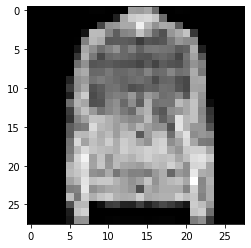

In [5]:
plt.imshow(image[63].numpy().squeeze(), cmap='gray')

#### Building Network

In [6]:
from collections import OrderedDict

input_size = 784
hidden_size = [256,128,64]
output_size = 10


model = nn.Sequential(OrderedDict([
    ('firstlayer', nn.Linear(input_size, hidden_size[0])),
    ('1st act func',nn.ReLU()),
    ('1st_dropout',nn.Dropout(0.5)),
    ('second layer', nn.Linear(hidden_size[0], hidden_size[1])),
    ('2nd act func', nn.ReLU()),
    ('2nd_dropout',nn.Dropout(0.5)),
    ('third layer', nn.Linear(hidden_size[1], hidden_size[2])),
    ('3rd act func', nn.ReLU()),
    ('output layer',nn.Linear(hidden_size[2],output_size)),
    ('output act func',nn.Softmax(dim=1))
])
)
model

Sequential(
  (firstlayer): Linear(in_features=784, out_features=256, bias=True)
  (1st act func): ReLU()
  (1st_dropout): Dropout(p=0.5, inplace=False)
  (second layer): Linear(in_features=256, out_features=128, bias=True)
  (2nd act func): ReLU()
  (2nd_dropout): Dropout(p=0.5, inplace=False)
  (third layer): Linear(in_features=128, out_features=64, bias=True)
  (3rd act func): ReLU()
  (output layer): Linear(in_features=64, out_features=10, bias=True)
  (output act func): Softmax(dim=1)
)

#### Training Network

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [8]:
def validation(model,testloader,criterion):
    test_loss=0
    test_acc =0
    
    for test_img, test_labels in testloader:
        test_img.resize_(test_img.shape[0],784)
        test_output = model.forward(test_img)
        test_loss += criterion(test_output, test_labels).item()
        
        ps= torch.exp(test_output) #give the exponential of probablity
        equality = (test_labels == ps.max(dim=1)[1])
        test_acc += equality.type(torch.FloatTensor).mean()

        
    return test_loss, test_acc
        

In [9]:
epochs =2
print_every = 40
steps =0

for e in range(epochs):
    model.train()
    running_loss =0
    for images, labels in trainloader:
        steps+=1
#         print(images.size())
        images.resize_(images.shape[0],784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() #get loss from tensor
        
        if steps % print_every == 0:
            print(steps)
            model.eval() # turn dropout off
            
            with torch.no_grad():
                test_loss, test_acc = validation(model,testloader,criterion)
                
                print('Epoch: {}/{}...'.format(e+1,epochs),
                      'Traning loss: {:.4f}...'.format(running_loss/print_every),
                      'Test Loss: {:.4f}...'.format(test_loss/len(testloader)),
                      'Test Accuracy: {:.4f}'.format(test_acc/len(testloader)) 
                     )#mean loss
                

            running_loss= 0
            
            model.train() #turn dropout on

40
Epoch: 1/2... Traning loss: -0.2520... Test Loss: -0.4608... Test Accuracy: 0.5051
80
Epoch: 1/2... Traning loss: -0.4905... Test Loss: -0.6107... Test Accuracy: 0.6456
120
Epoch: 1/2... Traning loss: -0.5800... Test Loss: -0.6168... Test Accuracy: 0.6169
160
Epoch: 1/2... Traning loss: -0.5930... Test Loss: -0.6456... Test Accuracy: 0.6543
200
Epoch: 1/2... Traning loss: -0.6172... Test Loss: -0.6564... Test Accuracy: 0.6622
240
Epoch: 1/2... Traning loss: -0.6303... Test Loss: -0.6707... Test Accuracy: 0.6734
280
Epoch: 1/2... Traning loss: -0.6610... Test Loss: -0.6810... Test Accuracy: 0.6814
320
Epoch: 1/2... Traning loss: -0.6769... Test Loss: -0.7302... Test Accuracy: 0.7378
360
Epoch: 1/2... Traning loss: -0.6995... Test Loss: -0.7239... Test Accuracy: 0.7289
400
Epoch: 1/2... Traning loss: -0.7204... Test Loss: -0.7469... Test Accuracy: 0.7516
440
Epoch: 1/2... Traning loss: -0.7331... Test Loss: -0.7537... Test Accuracy: 0.7577
480
Epoch: 1/2... Traning loss: -0.7332... Te

#### Make Prediction

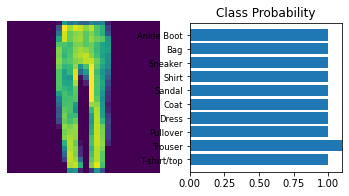

In [12]:
test_iter = iter(testloader)
test_images, test_labels = test_iter.next()
img = test_images[3]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(model(img)) #torch.exp == F.softmax ; torch.no_grad speed up the process (but here didnt use)

# Plot the image and probabilities
import udacity_helper as helper
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')